In [1]:
#imports from FitComparison_3panelPlot
import os
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy import constants as const

from scipy import interpolate
from scipy.optimize import minimize
from scipy.optimize import curve_fit

#from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck18  as cosmo# Planck 2018
from astropy.cosmology import Planck15  as cosmo2
from astropy.cosmology import z_at_value
from astropy.table import Table

from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap

############################
# Custom scripts
import get_ZdepSFRD as Z_SFRD

In [2]:
newcosmo =cosmo.clone(name='Planck18_modified', Om0=0.3089, Ob0 =0.0486)

In [3]:
#set values
Zsun = 0.014 #solar metallicity
mu_0      =0.025
mu_z      =-0.049
omega_0   =1.129
omega_z   =0.048
alpha  =-1.778

sf_a     =0.017
sf_b     =1.481
sf_c     =4.452
sf_d     =5.913

TNGlocation = '/home/sashalvna/research/Fit_SFRD_TNG100/'

In [4]:
path = TNGlocation+'SFRMetallicityFromGasTNG100.hdf5'
TNGmetallicities = h5.File(path, 'r')
list(TNGmetallicities.keys())

['Lookbacktimes', 'MetalBins', 'Redshifts', 'Sfr']

In [5]:
#read out "observed" values from TNG, and convert units of SFR
TNGlookbacktimes = TNGmetallicities['Lookbacktimes'][:]
TNGmetalbins = TNGmetallicities['MetalBins'][:]
TNGredshifts = TNGmetallicities['Redshifts'][:]
TNGsfr = TNGmetallicities['Sfr'][:]

# Convert SFR from sfr/box to sfr Mpc-3
littleh = 0.6774
Rbox    = 75/littleh
Obs_cosmic_SFR = TNGsfr / Rbox**3 *u.Mpc**-3
Obs_cosmic_SFR = Obs_cosmic_SFR.value
Obs_cosmic_SFR = Obs_cosmic_SFR.T

In [6]:
#Get centers of each metallicity bin, convert metallicity bins to log10 scale and find the Z steps betwen the bins
Obs_center_Zbin = (TNGmetalbins[:-1] + TNGmetalbins[1:])/2.
log_obs_metallicities = np.log10(TNGmetalbins)
step_obs_logZ = np.diff(log_obs_metallicities)[0]

In [7]:
#Calculate redshift from lookback time
z_from_lookbackt = [z_at_value(cosmo2.lookback_time,t*u.Gyr,method='Bounded') for t in TNGlookbacktimes[:-1]] 
z_from_lookbackt.insert(len(z_from_lookbackt),0) # put redshift zero at the end 
z_from_lookbackt = np.array(z_from_lookbackt)

Text(0.5, 0, 'Read in redshift')

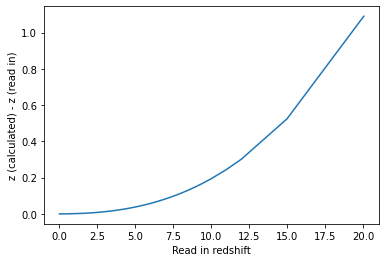

In [8]:
#Redshift calculated from lookback time and redshifts from file not the same? why?
plt.plot(TNGredshifts, (z_from_lookbackt-TNGredshifts))
plt.ylabel("z (calculated) - z (read in)")
plt.xlabel("Read in redshift")

In [9]:
print(TNGredshifts[0])

20.046490988807516


In [10]:
print(TNGlookbacktimes[0])

13.632737250584425


In [11]:
print(z_from_lookbackt[0])

21.136693929510507


## Things to try:

### Calculate lookback time from redshift

In [12]:
Lookbacktime_from_z  = [cosmo2.lookback_time(z).value for z in TNGredshifts]

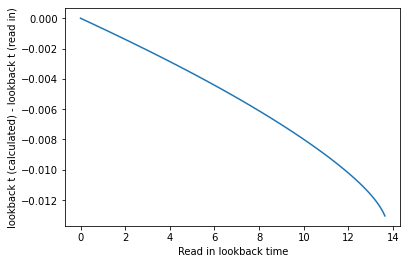

In [13]:
#Lookbacktime calculated from redshift - read in lookback time
plt.plot(TNGlookbacktimes, (Lookbacktime_from_z-TNGlookbacktimes))
plt.ylabel("lookback t (calculated) - lookback t (read in)")
plt.xlabel("Read in lookback time");

In [14]:
TNGlookbacktimes[0]

13.632737250584425

In [15]:
Lookbacktime_from_z[0]

13.61969300372921

### Astropy optimizer for z_at_value

In [16]:
#Default method "Brent"
redshifts_TNG = [z_at_value(cosmo2.lookback_time,t*u.Gyr,method='Brent') for t in TNGlookbacktimes[:-1]]
redshifts_TNG.insert(len(redshifts_TNG),0) # put redshift zero at the end 
redshifts_TNG = np.array(redshifts_TNG)

In [17]:
#method "Golden"
redshifts_TNG2 = [z_at_value(cosmo2.lookback_time,t*u.Gyr,method='Golden') for t in TNGlookbacktimes[:-1]]
redshifts_TNG2.insert(len(redshifts_TNG2),0) # put redshift zero at the end 
redshifts_TNG2 = np.array(redshifts_TNG2)

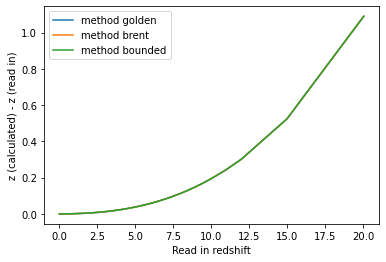

In [18]:
#Redshift calculated from lookback time and redshifts from file not the same? why?
plt.plot(TNGredshifts, (redshifts_TNG2-TNGredshifts),label= "method golden")
plt.plot(TNGredshifts, (redshifts_TNG-TNGredshifts), label= "method brent")
plt.plot(TNGredshifts, (z_from_lookbackt-TNGredshifts), label= "method bounded")
plt.ylabel("z (calculated) - z (read in)")
plt.xlabel("Read in redshift")
plt.legend()

### Check cosmology values

In [19]:
print(67.8 - 0.9, 67.8 + 0.9, cosmo2.H0)
print(.308 - 0.012, .308 + 0.012, cosmo2.Om0)

66.89999999999999 68.7 67.74 km / (Mpc s)
0.296 0.32 0.3075


In [20]:
print(67.8 - 0.9, 67.8 + 0.9, cosmo.H0)
print(.308 - 0.012, .308 + 0.012, cosmo.Om0)

66.89999999999999 68.7 67.66 km / (Mpc s)
0.296 0.32 0.30966
